# Thick Sample Ptychography Forward Model Tutorial 3D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 3D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a (\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2})  + C(x, y, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x,y, z) := \frac{k}{2i} \left(n^2(x,y, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume.**

### 1. Import Libraries: Sample Space and Forward Model


In [1]:
from thick_ptycho.sample_space.sample_space import SampleSpace
from thick_ptycho.forward_model.solver import ForwardModel

import numpy as np

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

In [2]:
bc_type = "impedance"               # Boundary condition type 
probe_type = "disk"                 # Airy disk probe

# Constants
wavelength = 0.635  # μm
k0 = 2 * np.pi / wavelength

# background refractive index
nb = 1.0  # background refractive index
# Define refractive index perturbation
# delta: real part, beta: imaginary part (absorption)
delta = 0.01
beta = 0.01
refractive_index_perturbation = - delta - beta*1j 

# Spatial dimensions
xlims = [0, 5000]  # μm
ylims = [0, 5000]  # μm
zlims = [0, 10]  # μm
continuous_dimensions = [xlims, ylims, zlims]


# Choose nz to satisfy paraxial resolution:
# Use approx. λ/4 axial resolution → ∆z ≈ λ / 4 ≈ 0.125 μm → nz = (z_range / ∆z)
z_range = zlims[1] - zlims[0]
dz = wavelength / 2
nz = int(z_range / dz)  
print(f"{nz=}")


# Discrete space parameters
probe_dimensions = [32,32]          # Detector shape can be different from discrete_dimensions
probe_diameter = int(0.9 * min(probe_dimensions))  # Diameter if using initial condition "disk"
scan_points = 3                     # Single probe
step_size = 20                     # Step size in pixels

# # Discrete space limits (pixels)
min_nx = int(scan_points * step_size + probe_dimensions[0])
print(min_nx)
if scan_points == 1:
    nx = probe_dimensions[0]
    ny = probe_dimensions[1]
else:
    nx = int(scan_points * step_size + probe_dimensions[0])
    ny = int(scan_points * step_size + probe_dimensions[1])
nx = 80#min_nx
ny = 80#min_nx
print(nx, ny)
discrete_dimensions = [
    nx, # can be larger than min_nx, 
    ny, # can be larger than min_ny
    nz
    ]   

nz=31
92
80 80


### 3. Create Sample Space

Initialize the sample space. The sample space dimensions are defined here as well
as it's discritization in pixels. The subdimensions

2025-09-23 08:01:44,308 - INFO - Summary of the scan (continuous):


2025-09-23 08:01:44,309 - INFO -     Sample space x: 5000 m
2025-09-23 08:01:44,311 - INFO -     Sample space y: 5000 m
2025-09-23 08:01:44,312 - INFO -     Sample space z: 10 m
2025-09-23 08:01:44,314 - INFO -     Probe Diameter: 1772.15 m
2025-09-23 08:01:44,315 - INFO -     Number of scan points: 9
2025-09-23 08:01:44,316 - INFO -     Max Overlap: 522.15 m 



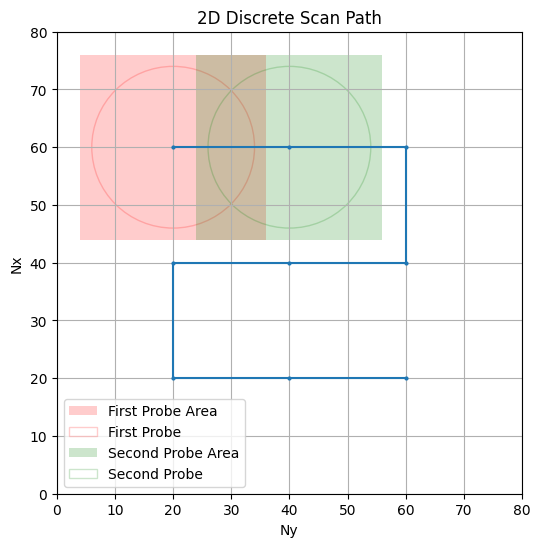

In [3]:
sample_space = SampleSpace(
    continuous_dimensions, # sample space dimensions in nanometers (x, z) or (x, y, z)
    discrete_dimensions,   # sample space dimensions in pixels (nx, nz) or (nx, ny, nz)
    probe_dimensions,        # shape of the detector in pixels - subset of (nx) or (nx, ny)
    scan_points,           # number of ptychography scan points or sqrt(scan_points) for square scan
    step_size,
    bc_type,               # boundary condition type (impedance, dirichlet, neumann)
    probe_type,
    k0,            # wavenumber in 1/nm
    probe_diameter=probe_diameter,  # diameter of the probe in pixels
    n_medium=nb,
)
sample_space_homogeneous = SampleSpace(
    continuous_dimensions, # sample space dimensions in nanometers (x, z) or (x, y, z)
    discrete_dimensions,   # sample space dimensions in pixels (nx, nz) or (nx, ny, nz)
    probe_dimensions,        # shape of the detector in pixels - subset of (nx) or (nx, ny)
    scan_points,           # number of ptychography scan points or sqrt(scan_points) for square scan
    step_size,
    bc_type,               # boundary condition type (impedance, dirichlet, neumann)
    probe_type,
    k0,            # wavenumber in 1/nm
    probe_diameter=probe_diameter,  # diameter of the probe in pixels
    n_medium=nb,
)
sample_space.summarize_sample_space()

### 4. Add Objects and Visualize Sample Space

Add cubiods, prisms or cylinders with specified refractive indices to the sample space.

Or load in your own sample space.

In [4]:
import random
random.seed(1)

# Add objects to the sample space and generate it
# Refractive index: n_b - e-4 - e-6i
# delta = 0.01
# beta = 0.01
# refractive_index = nb - delta - beta*1j 
# guassian_blur = 1.0 # removes sharp edges in the refractive index perturbation

# Generate the sample space
sample_space.load_cameraman(real_perturbation=delta, imaginary_perturbation=beta)  # Load a sample image

In [5]:
# # Alternatively, load in your own sample space
# filepath = "./data/simulated_spheres_128.npy"
# sample_space.load_sample_space(filepath)

In [6]:
# # Import Visualisation module
# from thick_ptycho.utils.visualisations import Visualisation

# visualisation = Visualisation(sample_space=sample_space)

# # Visualise the Sample Space
# transmission = np.exp(-1j * k0 * zlims[1] * (sample_space.n_true - nb))
# visualisation.plot(solution=transmission, slider=True, title=" (Sample Space Refractive Index)")

### 5. Solve the Forward Model

Solve the forward problem both iteratively and as a full system for sub-samples
and the full sample.

In [7]:
# Solve Full Space
thin_sample = True
forward_model_iterative_thin = ForwardModel(sample_space,
                             full_system_solver=False,
                             thin_sample=thin_sample)


# Iterative solution
print("Solving iteratively for thin sample...")
solution_iterative_thin = forward_model_iterative_thin.solve(verbose=True)


# # Compare
# error = np.abs(psi_expected - solution_iterative_thin)
# print("Max error:", np.max(error))

Solving iteratively for thin sample...
Time to solve scan 1/9: 0.1273784637451172 seconds
Time to solve scan 2/9: 0.10391902923583984 seconds
Time to solve scan 3/9: 0.14023542404174805 seconds
Time to solve scan 4/9: 0.10151529312133789 seconds
Time to solve scan 5/9: 0.14649343490600586 seconds
Time to solve scan 6/9: 0.10647034645080566 seconds
Time to solve scan 7/9: 0.11494112014770508 seconds
Time to solve scan 8/9: 0.11464571952819824 seconds
Time to solve scan 9/9: 0.10700678825378418 seconds


In [8]:
# tol = 1e-12
# real_part = np.real(solution_iterative_thin)
# imag_part = np.imag(solution_iterative_thin)
# mask = (np.abs(real_part) < tol) & (np.abs(imag_part) < tol)
# solution_iterative_thin[mask] = 0.0
if scan_points == 1:
    probe_idx = 0
    # Analytic solution
    probe = solution_iterative_thin[probe_idx,:,:,0]
    delta_n = sample_space.n_true - nb  # Refractive index perturbation
    object_slice =  np.exp(-1j * k0 * delta_n[:,:,0] * zlims[1])  # Take the first slice of the object
    psi_expected = probe * object_slice

    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(2, 2, figsize=(12, 5))

    # Amplitude plots
    amp_min = min(np.abs(psi_expected).min(), np.abs(solution_iterative_thin[probe_idx,:,:,-1]).min())
    amp_max = max(np.abs(psi_expected).max(), np.abs(solution_iterative_thin[probe_idx,:,:,-1]).max())

    im0 = axs[0, 0].imshow(np.abs(psi_expected), cmap='viridis', origin='lower', vmin=amp_min, vmax=amp_max)
    axs[0, 0].set_title('Amplitude of psi_expected')
    plt.colorbar(im0, ax=axs[0, 0])

    im2 = axs[1, 0].imshow(np.abs(solution_iterative_thin[0,:,:,-1]), cmap='viridis', origin='lower', vmin=amp_min, vmax=amp_max)
    axs[1, 0].set_title('Amplitude of solution_iterative_thin')
    plt.colorbar(im2, ax=axs[1, 0])

    # Phase plots
    phase_min = min(np.angle(psi_expected).min(), np.angle(solution_iterative_thin[probe_idx,:,:,-1]).min())
    phase_max = max(np.angle(psi_expected).max(), np.angle(solution_iterative_thin[probe_idx,:,:,-1]).max())

    im1 = axs[0, 1].imshow(np.angle(psi_expected), cmap='viridis', origin='lower', vmin=phase_min, vmax=phase_max)
    axs[0, 1].set_title('Phase of psi_expected')
    plt.colorbar(im1, ax=axs[0, 1])

    # Set tolerance for real and imaginary parts
    phase_solution = np.angle(solution_iterative_thin[probe_idx,:,:,-1])

    im3 = axs[1, 1].imshow(phase_solution, cmap='viridis', origin='lower', vmin=phase_min, vmax=phase_max)
    axs[1, 1].set_title('Phase of solution_iterative_thin')
    plt.colorbar(im3, ax=axs[1, 1])

    plt.tight_layout()
    plt.show()

In [9]:
# # Solve Full Space
# thin_sample = False
# full_system = False
# forward_model = ForwardModel(sample_space, thin_sample=thin_sample, 
#                                 full_system_solver=False)

# # Iterative solution
# print("Solving full sample...")
# solution_solve_full = forward_model.solve(verbose=True)

### 6. Solve in Reverse

The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

**To do:**
 - fix this for full system.
 - complete the test

In [10]:
# # Set Exit wave to initial condition for reverse
# print("Solving iteratively for thin sample in reverse...")
# initial_condition = solution_iterative_thin[..., -1].copy()  # Copy the last frame of the solution
# solution_iterative_thin_reverse = forward_model_iterative_thin.solve(reverse=True,
#                                                       initial_condition=initial_condition,
#                                                       verbose=True)

# import numpy as np
# # Compute RMSE between solution_iterative_solve_thin_reverse and itself
# rmse = np.sqrt(np.mean(np.abs(solution_iterative_thin[..., 0] - solution_iterative_thin_reverse[..., -1]) ** 2))
# print(f"RMSE between forward and backward solutions: {rmse}")

### 8. Visualisation of Solutions

Module to help view solutions.

In [11]:
# # Plotting the solution for thin sample
# if scan_points <= 12:
#     visualisation.plot(solution=solution_iterative_thin)
# # visualisation.plot(solution=(solution_iterative_thin), slider=True, probe_index=0)
# #solution_iterative_thin = solution_iterative_thin - solution_iterative_thin_homogeneous


TypeError: Invalid shape (9, 32, 31) for image data

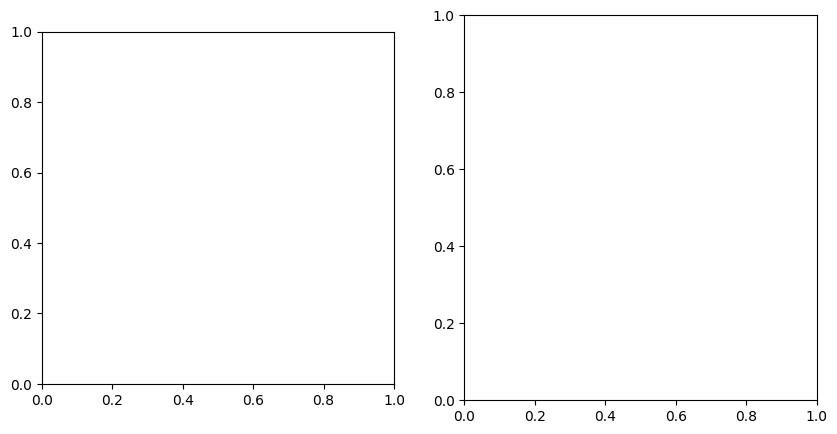

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter  # use ffmpeg if available

# Data
num_frames = solution_iterative_thin.shape[-1]
probe_idx = 0
amp = np.abs(solution_iterative_thin[probe_idx])
phase = np.angle(solution_iterative_thin[probe_idx])

# Consistent color scales
amp_min, amp_max = amp.min(), amp.max()

# Figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# NOTE: 'viridis' (spelled correctly)
im_phase = axs[0].imshow(phase[:, :, 0], cmap='viridis', origin='lower', vmin=-np.pi, vmax=np.pi)
axs[0].set_title('Phase')
cbar_phase = plt.colorbar(im_phase, ax=axs[0], ticks=[-np.pi, 0, np.pi])
cbar_phase.ax.set_yticklabels([r'$-\pi$', '0', r'$\pi$'])

im_amp = axs[1].imshow(amp[:, :, 0], cmap='viridis', origin='lower', vmin=amp_min, vmax=amp_max)
axs[1].set_title('Amplitude')
plt.colorbar(im_amp, ax=axs[1])

def update(frame):
    im_phase.set_data(phase[:, :, frame])
    im_amp.set_data(amp[:, :, frame])
    axs[0].set_ylabel(f'z-slice: {frame}')
    return [im_phase, im_amp]

ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=False, interval=50)

# --- Save ---

# Option A: MP4 via ffmpeg (requires ffmpeg installed and discoverable)
writer = FFMpegWriter(fps=20, bitrate=2000)
ani.save('solution_iterative_thin_movie.mp4', writer=writer, dpi=150)

# Option B (fallback): GIF via Pillow
# from matplotlib.animation import PillowWriter
# ani.save('solution_iterative_thin_movie.gif', writer=PillowWriter(fps=20), dpi=150)


In [ ]:
# # Plotting the solution for thin sample
# if scan_points <= 12:
#     visualisation.plot(solution=solution_solve_full)
# visualisation.plot(solution=solution_solve_full, slider=True, probe_index=0)

In [ ]:
# # Plot Solution for Full Sample Solves
# if nx <= 80 and ny <= 80 and propagation_slices <= 20:
#     visualisation.plot(solution=solution_solve_full)
#     visualisation.plot(solution=solution_solve_full, slider=True, probe_index=0)
# else:
#     print("Skipping full space solution visualisation for large sample space dimensions (nx, ny > 80, nz > 20).")

### 7. Save thin sample data to Tiff Files for Ptychography Reconstructions

In [ ]:
import tifffile as tiff
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

save_dir = Path("./results")
save_dir.mkdir(exist_ok=True)

# Save the data as a numpy file
exit_wave = solution_iterative_thin[:,:,:,-1]  # Get the exit waves from the solution
probe = solution_iterative_thin[:,:,:,0]  # Get the probe from the solution
for j in range(exit_wave.shape[0]):
    exit_wave[j, :, :] = np.flipud(exit_wave[j, :, :])
    probe[j, :, :] = np.flipud(probe[j, :, :])

    
data = np.zeros_like(exit_wave, dtype=np.float32)

for frame_number in range(sample_space.num_probes):
    data[frame_number, :, :] = np.random.poisson(np.square(np.abs(np.fft.fftshift(np.fft.fft2(exit_wave[frame_number, :, :])))))
np.save(save_dir / 'data.npy', data)
np.save(save_dir / 'exit_wave.npy', exit_wave)
np.save(save_dir / 'probe.npy', probe)

# Save the object field cross section as a tif file
object_field_cross_section = transmission[:, :, int(sample_space.nz / 2)]
object_field_cross_section = np.flipud(object_field_cross_section)
object_field_cross_section_modulus = np.abs(object_field_cross_section).astype(np.float32) 
object_field_cross_section_phase = np.angle(object_field_cross_section).astype(np.float32) 
tiff.imwrite(save_dir / 'object_field_cross_section_phase.tif', object_field_cross_section_phase)
object_field_cross_section = np.flipud(object_field_cross_section)
tiff.imwrite(save_dir / 'object_field_cross_section_modulus.tif', object_field_cross_section_modulus)

# Save the parameters as a json file
if bc_type == "dirichlet":
    probe_dimensions = [probe_dimensions[0]+2, probe_dimensions[1]+2]

parameters = {
    "detector_shape": probe_dimensions,
    "probe_diameter": probe_diameter,
    "scan_step_size": step_size,
    "scan_points_xy": scan_points,
    "probe_type": probe_type
}

with open(save_dir / 'parameters.json', 'w') as json_file:
    json.dump(parameters, json_file)

/tmp/ipykernel_53691/764783569.py:28: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(data[frame_number, :, :]), cmap='gray', origin='lower')


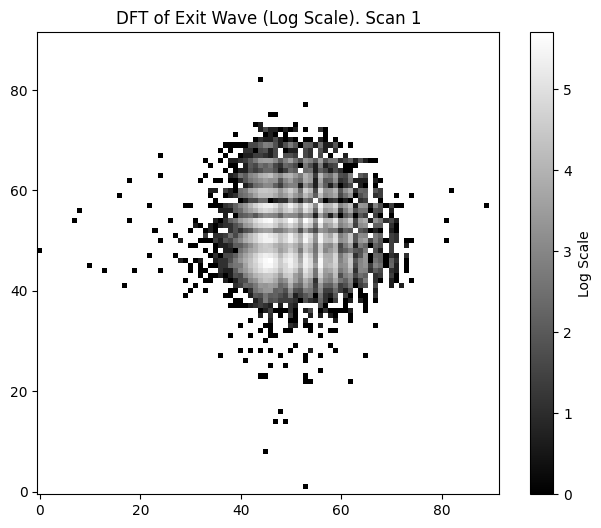

/tmp/ipykernel_53691/764783569.py:13: RuntimeWarning: divide by zero encountered in log
  im_r = axes_re[row, col].imshow(np.log(data[idx, :, :]), cmap='gray',origin='lower')


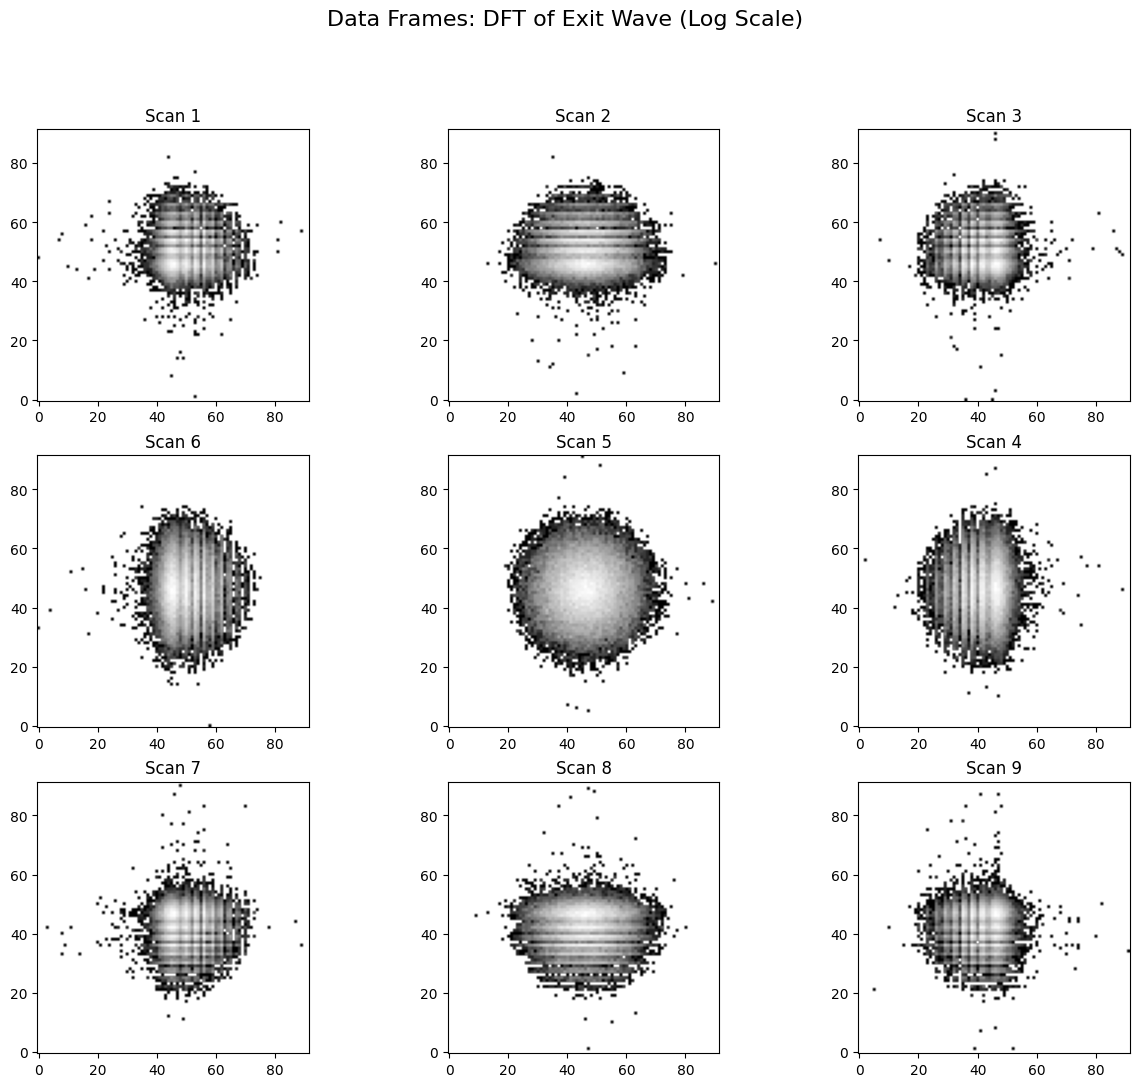

In [ ]:
def plot_data(data, scan_points_xy):
    fig_re, axes_re = plt.subplots(scan_points_xy, scan_points_xy, figsize=(15, 12), squeeze=False)

    num_probes = data.shape[0]  # Number of frames

    for idx in range(num_probes):
        row = idx // scan_points_xy
        if row % 2 == 0:  # Even row (left to right)
            col = idx % scan_points_xy
        else:  # Odd row (right to left)
            col = scan_points_xy - 1 - ( idx % scan_points_xy )

        im_r = axes_re[row, col].imshow(np.log(data[idx, :, :]), cmap='gray',origin='lower')
        axes_re[row, col].set_title(f'Scan {idx+1}')

    fig_re.suptitle('Data Frames: DFT of Exit Wave (Log Scale)', fontsize=16)
    plt.show()

def plot_single_frame(data, frame_number):
    """
    Plot a single frame of the data.
    
    Parameters:
    - data: numpy array containing the data
    - frame_number: index of the frame to plot
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(np.log(data[frame_number, :, :]), cmap='gray', origin='lower')
    plt.title(f'DFT of Exit Wave (Log Scale). Scan {frame_number + 1}')
    plt.colorbar(label='Log Scale')
    plt.show()

plot_single_frame(data, 0)  # Plot the first frame as an example

# Example usage
if scan_points <= 12:
    plot_data(data, scan_points)  # Adjust scan_points_xy as needed